In [8]:
from ddpm.denoising_diffusion_pytorch import *
from datasets import load_dataset, concatenate_datasets
import torch
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%load_ext autoreload
%autoreload 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
DEVICE

device(type='cuda')

In [3]:
class ResnetClassifier(nn.Module):
    def __init__(self, dim, dim_out, *, groups = 8):
        super().__init__()

        self.block1 = Block(dim, dim_out)
        self.block2 = Block(dim_out, dim_out)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x):
        h = self.block1(x)
        h = self.block2(h)
        return h + self.res_conv(x)

In [9]:
# meta data
metadata = load_dataset("parquet", data_files="/pscratch/sd/s/sihany/smithgalaxies/galaxies/metadata.parquet", split="train")
meta_sorted = metadata.sort("dr8_id")
# meta_sorted = meta_sorted.with_format("torch", device=DEVICE)

In [10]:
ds = load_dataset("parquet", data_files={'train': '/pscratch/sd/s/sihany/smithgalaxies/galaxies/data/train*'}, split="train")

ds = ds.sort("dr8_id")
# ds = ds.with_format("torch", device=DEVICE)
ids_train = set(ds['dr8_id'])
meta_train = meta_sorted.filter(lambda example: example["dr8_id"] in ids_train, num_proc = 4)
assert len(meta_train['dr8_id']) == len(ds['dr8_id'])
assert meta_train['dr8_id'] == ds['dr8_id']


# select only rows with good specz
inds = [example is not None for example in meta_train['spec_z']]
import numpy as np
inds = np.arange(len(meta_train))[np.array(inds)]

ds = ds.select(inds)
meta_train = meta_train.select(inds)

# merge datasets
ds = concatenate_datasets([ds, meta_train.select_columns(['spec_z', 'mass_inf_photoz', 'sfr_inf_photoz'])], axis = 1)

ds = ds.filter(lambda example: (example["mass_inf_photoz"] > 0) & (example["sfr_inf_photoz"] > -10), num_proc = 4)
print(len(ds))

Resolving data files:   0%|          | 0/192 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/1903 [00:00<?, ?it/s]

1062698


In [11]:
from torchvision import transforms

# send to cuda
ds = ds.with_format("torch", device=DEVICE)

# Preprocessing the datasets and DataLoaders creation.
augmentations = transforms.Compose(
    [
            transforms.CenterCrop((128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
    ]
)

def transform_images(examples):
    images = [augmentations(image.convert("RGB")) for image in examples["image"]]
    return {"image": images, "dr8_id": examples['dr8_id'], "spec_z": examples['spec_z'], 
            "mass_inf_photoz": examples['mass_inf_photoz'], "sfr_inf_photoz": examples['sfr_inf_photoz']}

ds.set_transform(transform_images)


In [149]:
from torch.utils import data as datal

dl = cycle(datal.DataLoader(ds, batch_size = 16, shuffle=True))

In [155]:
import torch.nn as nn
import torchvision.models as models

class ResNetOutput3(nn.Module):
    def __init__(self, num_outputs=3):
        super(ResNetOutput3, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = models.resnet101(pretrained=True)  # You can choose resnet18, resnet34, resnet101, etc.
        
        # Modify the final fully connected layer to output 3 parameters
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_outputs)
    
    def forward(self, x):
        return self.resnet(x)


In [156]:
wandb.init()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,█▇▆▄▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
lr,▁▁▂▃▃▄▄▅▅▆▆▇█████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val loss,██▅▃▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
loss,2.91308
lr,7e-05
step,2999
val loss,1.11435


In [157]:
from torch.optim import AdamW, lr_scheduler
from tqdm import tqdm

def custom_loss(model_out, specz, smass, sfr):
    return torch.mean((model_out[:, 0] - specz)**2/0.3**2 + (model_out[:, 1] - smass)**2/2**2 + (model_out[:, 2] - sfr)**2/1**2)

mymodel = ResNetOutput3().to(device=DEVICE)

train_lr = 2e-4
train_num_steps = 3000
gradient_accumulate_every = 4
update_ema_every = 10
sample_every = 100

opt = AdamW(mymodel.parameters(), lr=train_lr)
# self.lr_scheduler = lr_scheduler.OneCycleLR(self.opt, train_lr, total_steps = train_num_steps, pct_start = 0.08)
lr_scheduler = lr_scheduler.CyclicLR(opt, train_lr/1e4, train_lr, 
    step_size_up = 1000, step_size_down = 3000, mode = 'triangular')

step = 0
loop = tqdm(range(train_num_steps), disable= False, position=0, leave = True)
for _ in loop:
# while self.step < self.train_num_steps:
    for i in range(gradient_accumulate_every):
        ele = next(dl)
        data = ele['image'].to(device=DEVICE)
        while torch.any(~torch.isfinite(data)):
            print("NAN DETECTED!!")
            ele = next(dl)
            data = ele['image'].to(device=DEVICE)
        pred = mymodel(data)
        # print(pred.shape, ele['spec_z'].shape)
        loss = custom_loss(pred, ele['spec_z'].to(device=DEVICE), 
                           ele['mass_inf_photoz'].to(device=DEVICE), 
                           ele['sfr_inf_photoz'].to(device=DEVICE))
        (loss / gradient_accumulate_every).backward()
        # print(loss)
        # print(loss.item())
        loop.set_description(f'loss = {loss.item()}')
        wandb.log({'loss': loss.item(), 'step': step, 'lr': lr_scheduler.get_last_lr()[0]})

    opt.step()
    lr_scheduler.step()
    opt.zero_grad()

    if step % sample_every == 0: #  and self.step > 0:
        mymodel.eval()
        ele = next(dl)
        data = ele['image'].to(device=DEVICE)
        while torch.any(~torch.isfinite(data)):
            print("NAN DETECTED!!")
            ele = next(dl)
            data = ele['image'].to(device=DEVICE)
        pred = mymodel(data)
        # print(pred.shape, ele['spec_z'].shape)
        valloss = custom_loss(pred, ele['spec_z'].to(device=DEVICE), 
                           ele['mass_inf_photoz'].to(device=DEVICE), 
                           ele['sfr_inf_photoz'].to(device=DEVICE))
        wandb.log({'val loss': valloss.item(), 'step': step, 'lr': lr_scheduler.get_last_lr()[0]})
        mymodel.train()

    step += 1

/global/common/software/desi/users/sihany/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/global/common/software/desi/users/sihany/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /global/homes/s/sihany/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 108MB/s]  
loss = 1.8305137810728866: 100%|██████████| 3000/3000 [20:34<00:00,  2.43it/s] 


In [158]:
# testing the model
testdl = cycle(datal.DataLoader(ds, batch_size = 16, shuffle=True))

truth = []
pred = []
for i in tqdm(range(1000)):
    ele = next(testdl)
    data = ele['image'].to(device=DEVICE)

    pred += [mymodel(data).cpu().detach().numpy()]
    
    tru_z = ele['spec_z'].numpy()
    tru_sm = ele['mass_inf_photoz'].numpy()
    tru_sfr = ele['sfr_inf_photoz'].numpy()
    truth += [np.vstack([tru_z, tru_sm, tru_sfr]).T]
    
truth = np.concatenate(truth)
pred = np.concatenate(pred)

100%|██████████| 1000/1000 [01:14<00:00, 13.43it/s]


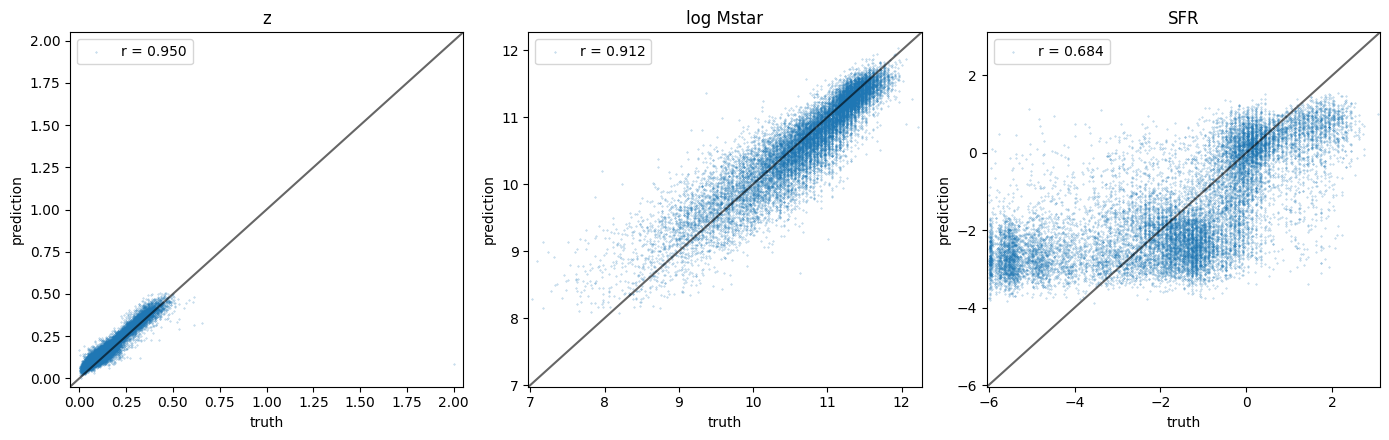

In [159]:
import matplotlib.pyplot as plt
from scipy import stats

fig, ax = plt.subplots(figsize = (14, 4.5), ncols = 3, nrows = 1)
titles = ['z', 'log Mstar', 'SFR']
for i in range(3):
    xmin = np.min(truth[:, i])-0.05
    xmax = np.max(truth[:, i])+0.05
    fakex = np.linspace(xmin, xmax, 10)
    ax[i].plot(fakex, fakex, 'k', alpha = 0.6)
    res = stats.pearsonr(truth[:, i], pred[:, i])
    ax[i].scatter(truth[:, i], pred[:, i], s = 0.1, alpha = 0.5, label = 'r = '+str(res.statistic)[:5])
    ax[i].set_xlabel('truth')
    ax[i].set_ylabel('prediction')
    ax[i].set_xlim(xmin, xmax)
    ax[i].set_ylim(xmin, xmax)
    ax[i].set_title(titles[i])
    ax[i].legend()
plt.tight_layout()

In [160]:
# test our model 
from ddpm.denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer, Galaxies

batchsize = 64
testdl = cycle(datal.DataLoader(ds, batch_size = batchsize, shuffle=True))

model = Unet(
    dim = 128,
    dim_mults = (1, 1, 2, 2, 2, 4, 4, 4),
    dim_cond = 3
).to(device=DEVICE)

diffusion = GaussianDiffusion(
    model,
    image_size =128,
    timesteps = 1000,
    loss_type = 'l2'
).to(device=DEVICE)


trainer = Trainer(
    diffusion,
    dl = dl,
    logdir = '/pscratch/sd/s/sihany/logs/desi_cond/',
    image_size = 128,
    train_batch_size = 16,
    train_lr = 1e-4,
    train_num_steps = 100000,         # total training steps
    gradient_accumulate_every = 1,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    step_start_ema = 5000,
    save_every = 5000,
    sample_every = 3000,
    num_workers=16,
    cond = True,
    # smoothz = True,
    # alpha = 0.1
)

milestone = 240000
trainer.load(milestone)

truth_model = []
pred_model = []
for i in tqdm(range(30)):
    ele = next(testdl)
    ims_tru = ele['image'].to(device=DEVICE)
    tru_z = ele['spec_z']
    tru_sm = ele['mass_inf_photoz']
    tru_sfr = ele['sfr_inf_photoz']
    
    conditioning = torch.zeros(batchsize, 3)
    conditioning[:, 0] = tru_z
    conditioning[:, 1] = tru_sm
    conditioning[:, 2] = tru_sfr
    conditioning = conditioning.to(torch.float32).to(device=DEVICE)

    ims_pred = trainer.ema_model.module.sample(128, batch_size = batchsize, cond = conditioning)
    
    truth_model += [np.vstack([tru_z.numpy(), tru_sm.numpy(), tru_sfr.numpy()]).T]
    pred_model += [mymodel(ims_pred).cpu().detach().numpy()]

sampling loop time step:  20%|██        | 200/1000 [00:27<01:48,  7.34it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

sampling loop time step:  65%|██████▌   | 653/1000 [01:28<00:47,  7.35it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [161]:
truth_model = np.concatenate(truth_model)
pred_model = np.concatenate(pred_model)

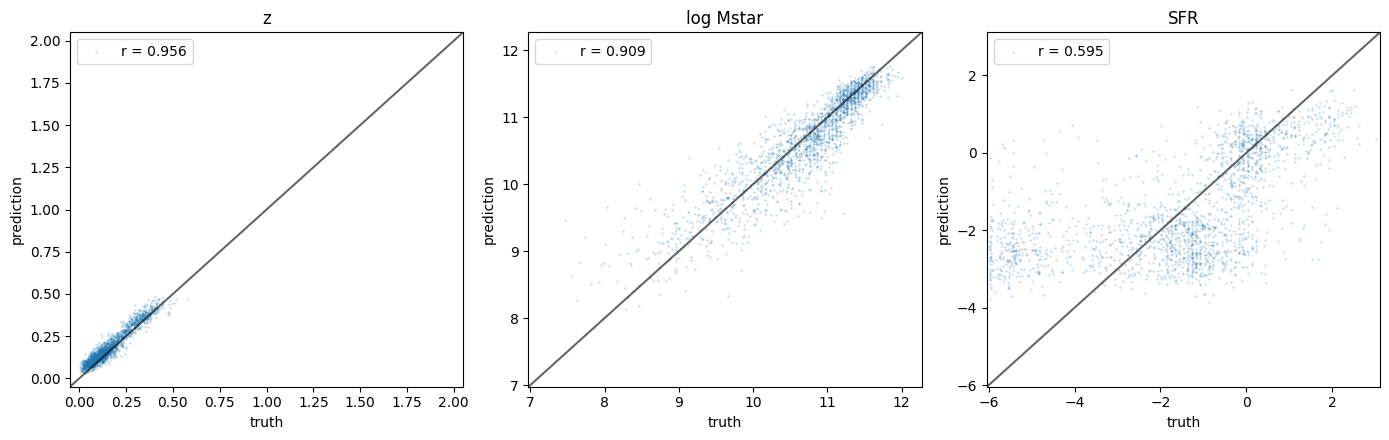

In [162]:
fig, ax = plt.subplots(figsize = (14, 4.5), ncols = 3, nrows = 1)
titles = ['z', 'log Mstar', 'SFR']
for i in range(3):
    xmin = np.min(truth[:, i])-0.05
    xmax = np.max(truth[:, i])+0.05
    fakex = np.linspace(xmin, xmax, 10)
    ax[i].plot(fakex, fakex, 'k', alpha = 0.6)
    res = stats.pearsonr(truth_model[:, i], pred_model[:, i])
    ax[i].scatter(truth_model[:, i], pred_model[:, i], s = 0.1, alpha = 0.5, label = 'r = '+str(res.statistic)[:5])
    ax[i].set_xlabel('truth')
    ax[i].set_ylabel('prediction')
    ax[i].set_xlim(xmin, xmax)
    ax[i].set_ylim(xmin, xmax)
    ax[i].set_title(titles[i])
    ax[i].legend()
plt.tight_layout()
# fig.savefig('./')

In [ ]:
# alpha = 0.001, mil = 80000, r = 0.877/0.904/0.567
# alpha = 0.001, mil = 130000, r = 0.94/0.895/0.591, repeat (0.934/0.897/0.615)
# alpha = 0.1, mil = 250000, r = 0.953/0.908/0.609, repeat (0.950/0.908/0.616)
# alpha = 0, mil = 240000, r = 0.958/0.908/0.632